In [1]:
import sys
sys.path.append('../src/')
import itertools
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from evaluation_metrics import *
from models import *
from priors import *
from utils import *

In [3]:
def plot_experiment(df, labels):
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    
    mle_rmse = np.zeros(len(labels))
    gp_rmse = np.zeros(len(labels))
    baseline1 = np.zeros(len(labels))
    baseline2 = np.zeros(len(labels))
    likelihoods = np.zeros(len(labels))
    coverage = np.zeros(len(labels))
    
    for label_index, _ in enumerate(labels):
        # Plot data
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train power law model
        #"""
        model, losses = train_PowerLaw(X_train, y_train)
        model.eval()
        with torch.no_grad():
            observed_pred = model(torch.linspace(200, 30000, 1000))
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')
        # RMSE
        mle_rmse[label_index]\
        = rmse(y_test.detach().numpy(), model(X_test).detach().numpy())        
        #"""
        # Train Gaussian process
        #"""
        likelihood, model, losses = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(200, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Gaussian process (ours)')
        np.array(axs).flatten()[label_index]\
        .fill_between(np.linspace(200, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # RMSE
        gp_rmse[label_index]\
        = rmse(y_test.detach().numpy(), model(X_test).mean.detach().numpy())
        # Log-likelihood
        baseline1[label_index] = uniform_log_likelihood(y_test, 0.5)
        baseline2[label_index] = uniform_log_likelihood(y_test, float(torch.min(y_train)))
        #log_likelihood = truncated_normal_likelihood(y_test, 0, 1, likelihood(model(X_test)).mean.detach().numpy(), likelihood(model(X_test)).stddev.detach().numpy())
        log_likelihood = truncated_normal_likelihood(y_test, -np.inf, np.inf, likelihood(model(X_test)).mean.detach().numpy(), likelihood(model(X_test)).stddev.detach().numpy())
        likelihoods[label_index] = log_likelihood
        # Coverage
        loc = likelihood(model(X_test)).mean.detach().numpy()
        scale = likelihood(model(X_test)).stddev.detach().numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        coverage[label_index]\
        = calc_coverage(y_test.detach().numpy(), lower, upper)        
        #"""

        # Formatting
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples (log-scale)')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        #np.array(axs).flatten()[label_index]\
        #.legend(loc='lower right')
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    print('Power law RMSE: {}'.format(mle_rmse*100))
    print('GP RMSE: {}'.format(gp_rmse*100))
    print('Uniform [0.5, 1] log-likelihood: {}'.format(baseline1))
    print('Uniform [min(v(n_{{1:m}})), 1] log-likelihood: {}'.format(baseline2))
    print('GP log-likelihood: {}'.format(likelihoods))
    print('GP coverage: {}'.format(coverage*100))
    fig.tight_layout()
    plt.show()

[0.15556544 0.23334816]
0.030202020202020206 0.008424242424242424
[0.02300089 0.03713238]
[0.15276191 0.23378244]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.2285], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([1.0626], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.1916], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-3.7518], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-7.2458, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.0897]], requires_grad=True)
Variance: 0.17107033794929505
Tau: 0.009999999873689375
Outputscale: 0.02670053090245672
Lengthscale: 0.7389769554138184
[0.12331307 0.1849696 ]
0.02277777777777778 0.0064444444444444445
[0.01747464 0.02813933]
[0.12272779 0.18388618]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.2946], requires_grad=True)
mean_module.one_minus_epsil

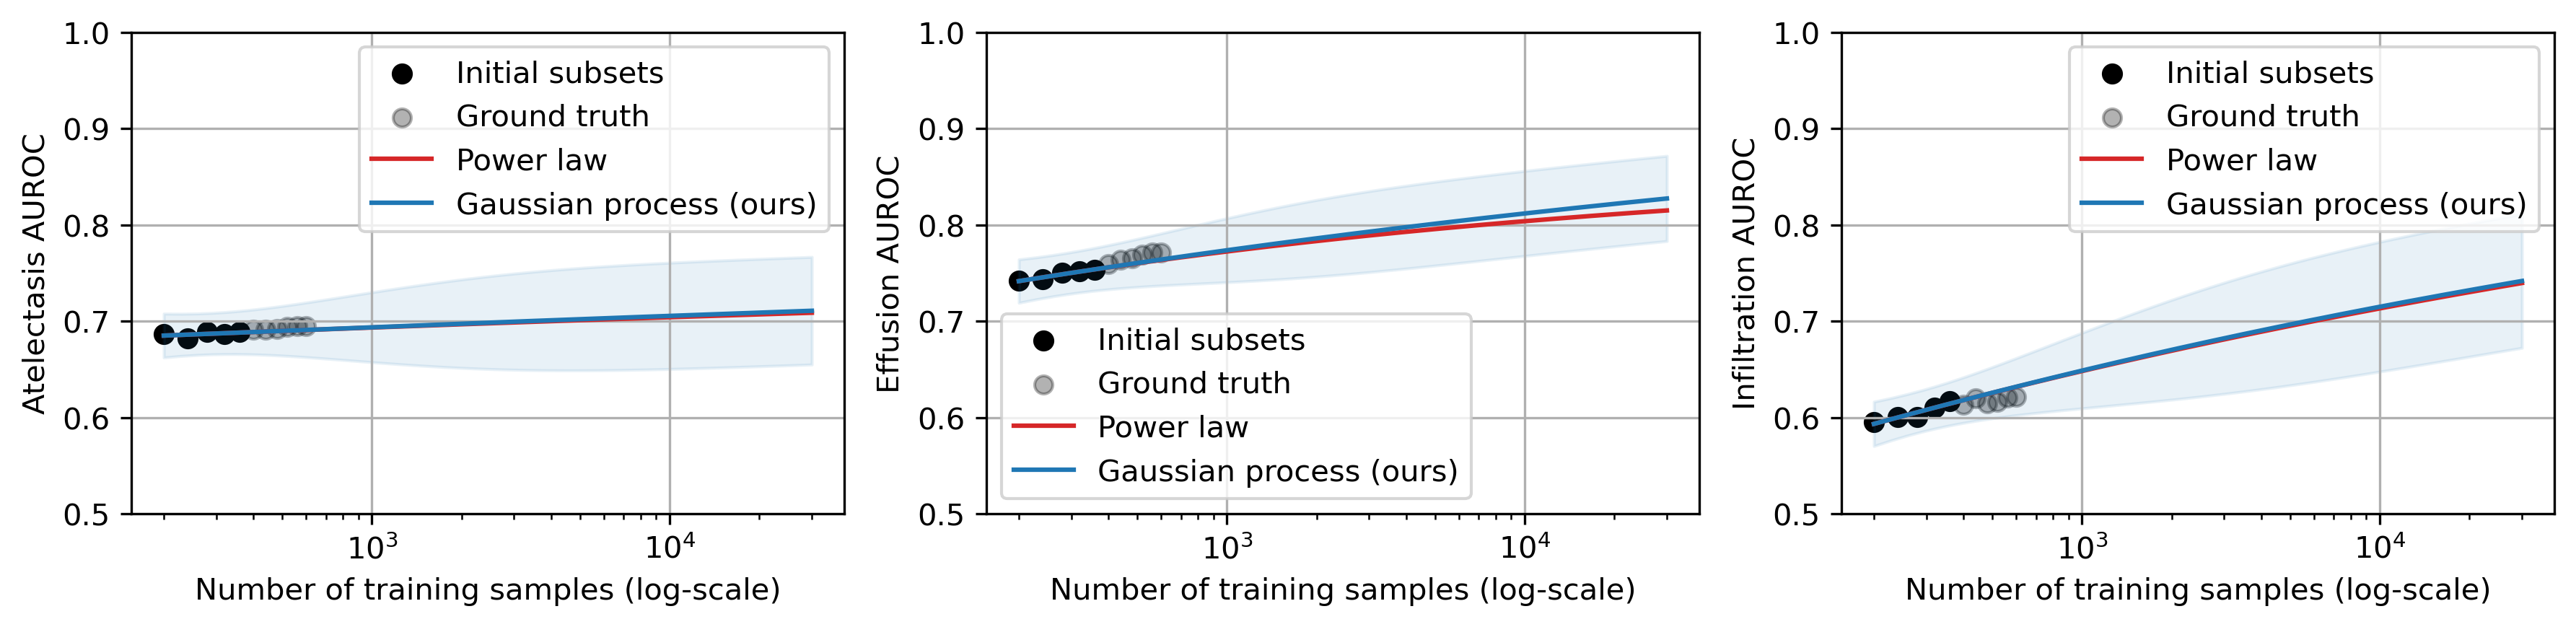

In [4]:
# ChestX-ray14 (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_short_range.csv')
plot_experiment(df, ['Atelectasis', 'Effusion', 'Infiltration'])

[0.15556544 0.23334816]
0.030202020202020206 0.007929292929292928
[0.02353589 0.03710686]
[0.15588574 0.23302617]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.2272], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([1.0964], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.1829], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-3.7607], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-7.2129, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.1016]], requires_grad=True)
Variance: 0.1735560773495854
Tau: 0.009999999873689375
Outputscale: 0.02714248006964509
Lengthscale: 0.7452163696289062
[0.12331307 0.1849696 ]
0.02277777777777778 0.0064444444444444445
[0.0172928 0.0281186]
[0.12120416 0.18388917]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.2946], requires_grad=True)
mean_module.one_minus_epsilon 

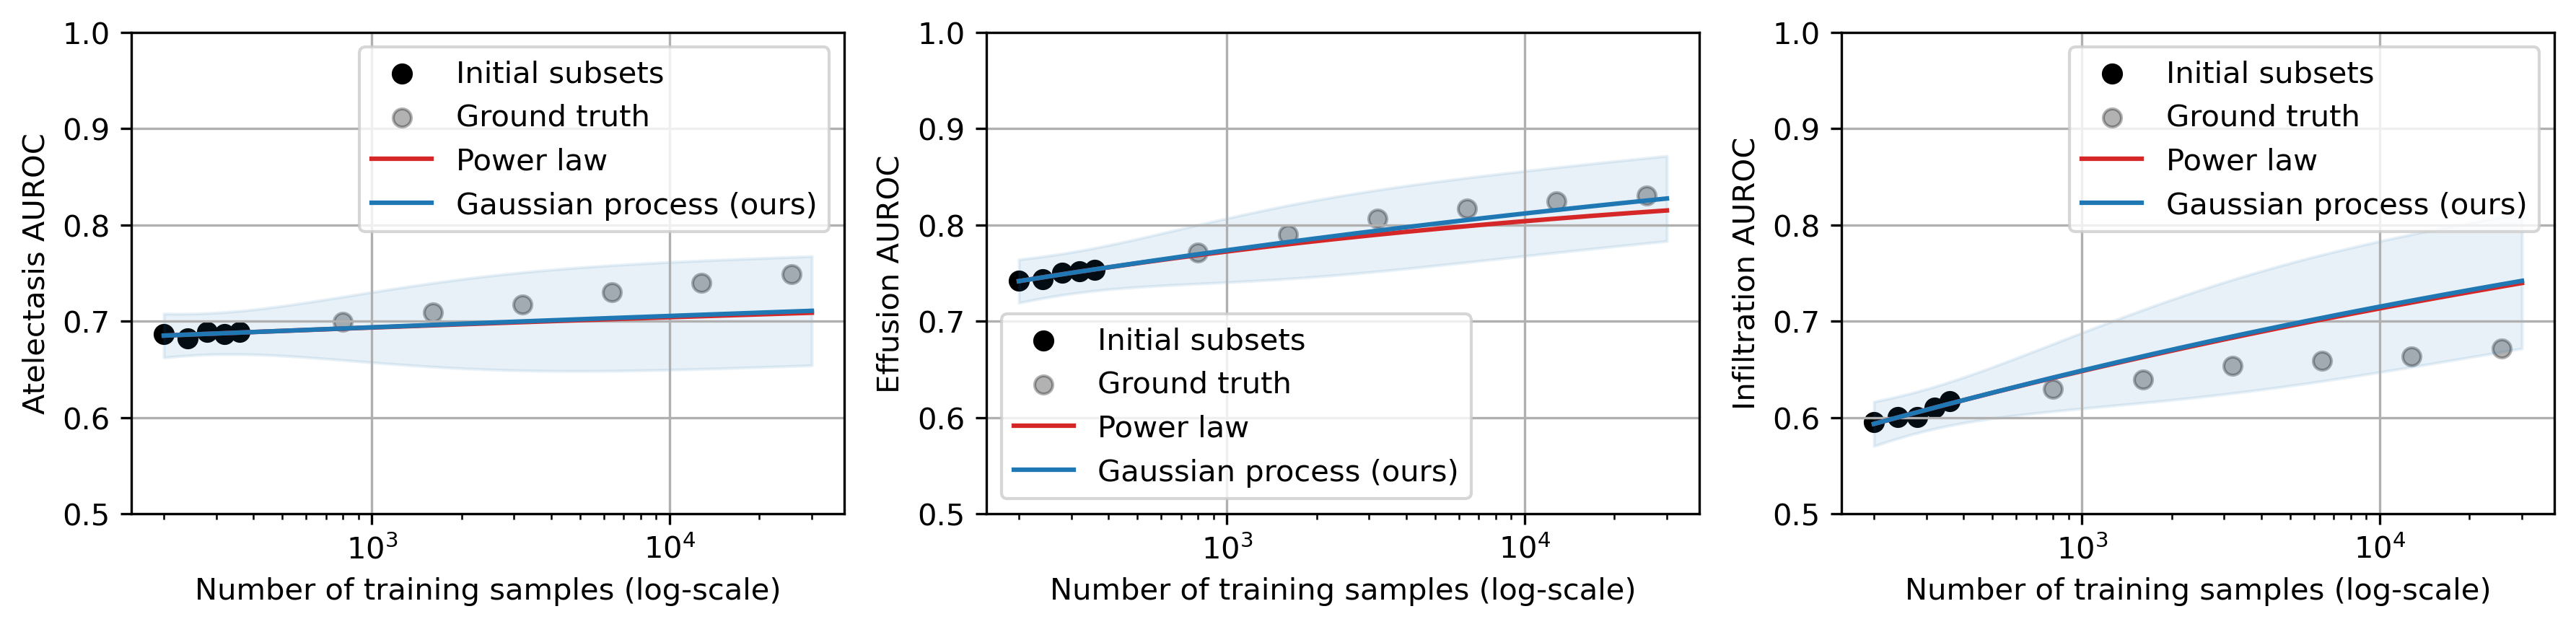

In [5]:
# ChestX-ray14 (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv')
plot_experiment(df, ['Atelectasis', 'Effusion', 'Infiltration'])

[0.06745741 0.10118611]
0.009414141414141413 0.001
[0.00856894 0.01025413]
[0.068056   0.10298025]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.3491], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([13.8248], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.7764], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-1.5556], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-9.3538, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-0.7867]], requires_grad=True)
Variance: 0.08196706900734489
Tau: 0.009999999873689375
Outputscale: 0.009307405194847226
Lengthscale: 0.37523868680000305
[0.10719237 0.16078855]
0.019313131313131313 0.005454545454545455
[0.01470954 0.02387079]
[0.10790666 0.16071949]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.3002], requires_grad=True)
mean_module.one_minus_epsilon Paramete

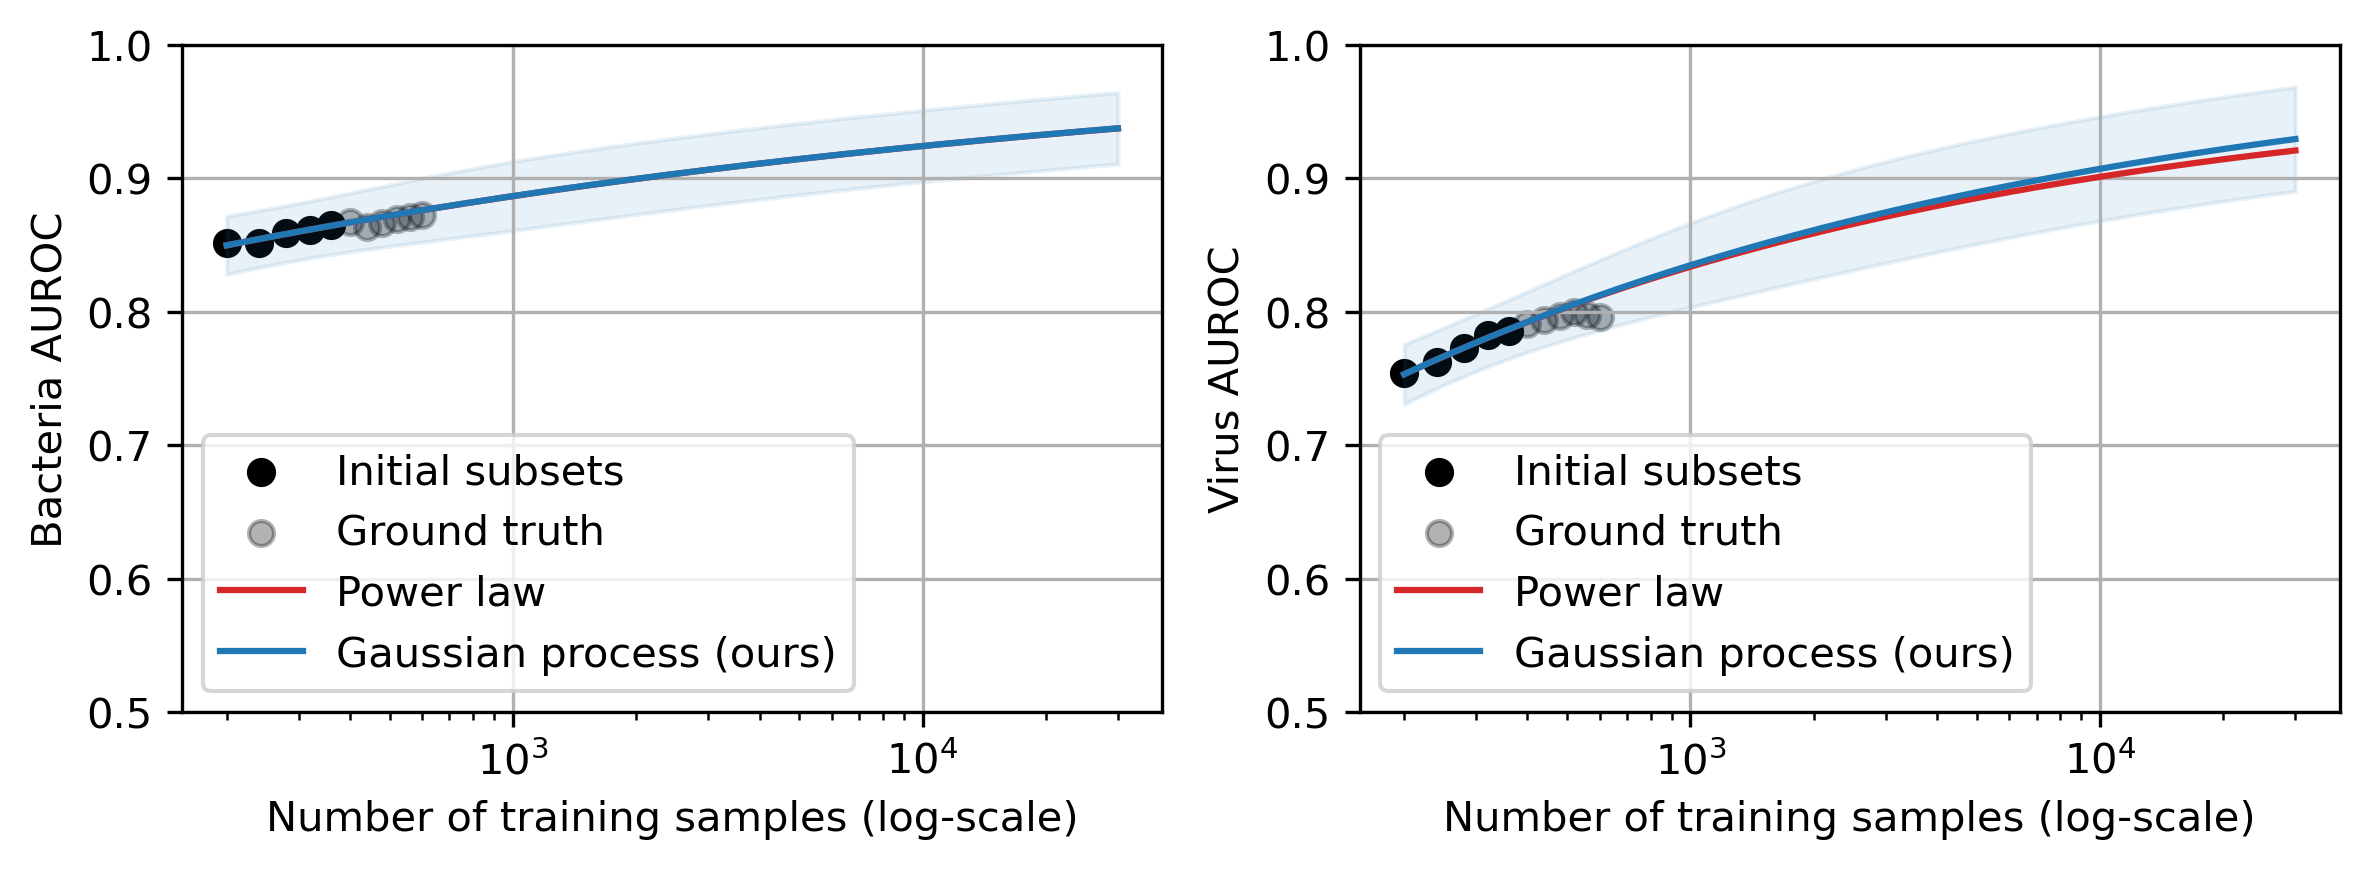

In [6]:
# Chest X-Ray (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_short_range.csv')
plot_experiment(df, ['Bacteria', 'Virus'])

[0.06745741 0.10118611]
0.009414141414141413 0.001494949494949495
[0.00816891 0.01065919]
[0.06761191 0.10398243]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.3506], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([13.6997], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.7763], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-1.5558], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-9.3826, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-0.8011]], requires_grad=True)
Variance: 0.08142520290503574
Tau: 0.009999999873689375
Outputscale: 0.009174335820752442
Lengthscale: 0.37076786160469055
[0.10719237 0.16078855]
0.019313131313131313 0.005454545454545455
[0.01468955 0.02387982]
[0.10719693 0.16101452]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.3002], requires_grad=True)
mean_module.one_minus_e

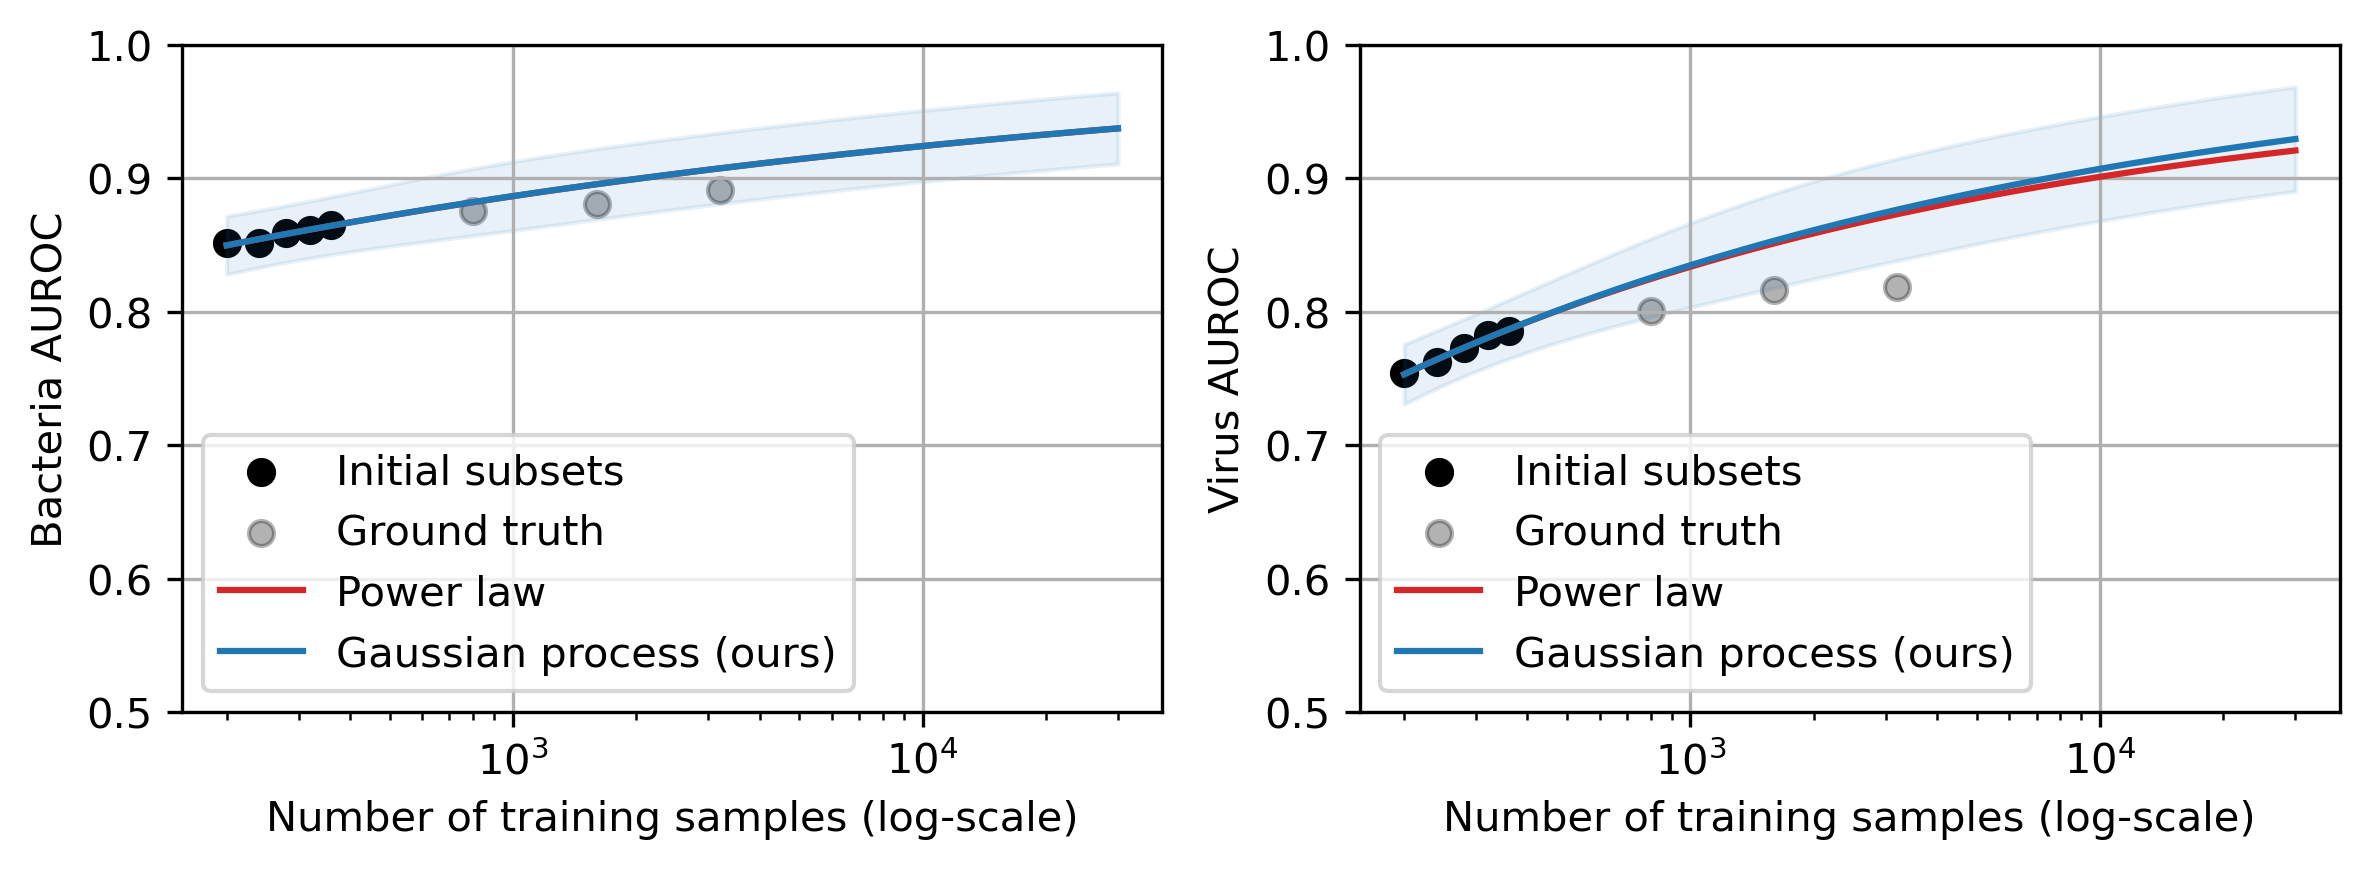

In [7]:
# Chest X-Ray (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_long_range.csv')
plot_experiment(df, ['Bacteria', 'Virus'])

[0.02664262 0.03996393]
0.001 0.001
[0.00056949 0.00195536]
[0.03710477 0.08608252]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-29.5322], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([13.9786], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-2.1388], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.0064], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-13.9070, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-20.7001]], requires_grad=True)
Variance: 0.06027315656806053
Tau: 0.009999999873689375
Outputscale: 0.0009552994530743198
Lengthscale: 1.0234773029083044e-09
[0.06235752 0.09353627]
0.007929292929292928 0.001
[0.00708126 0.00876964]
[0.06051903 0.09894895]
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-11.4141], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([-1

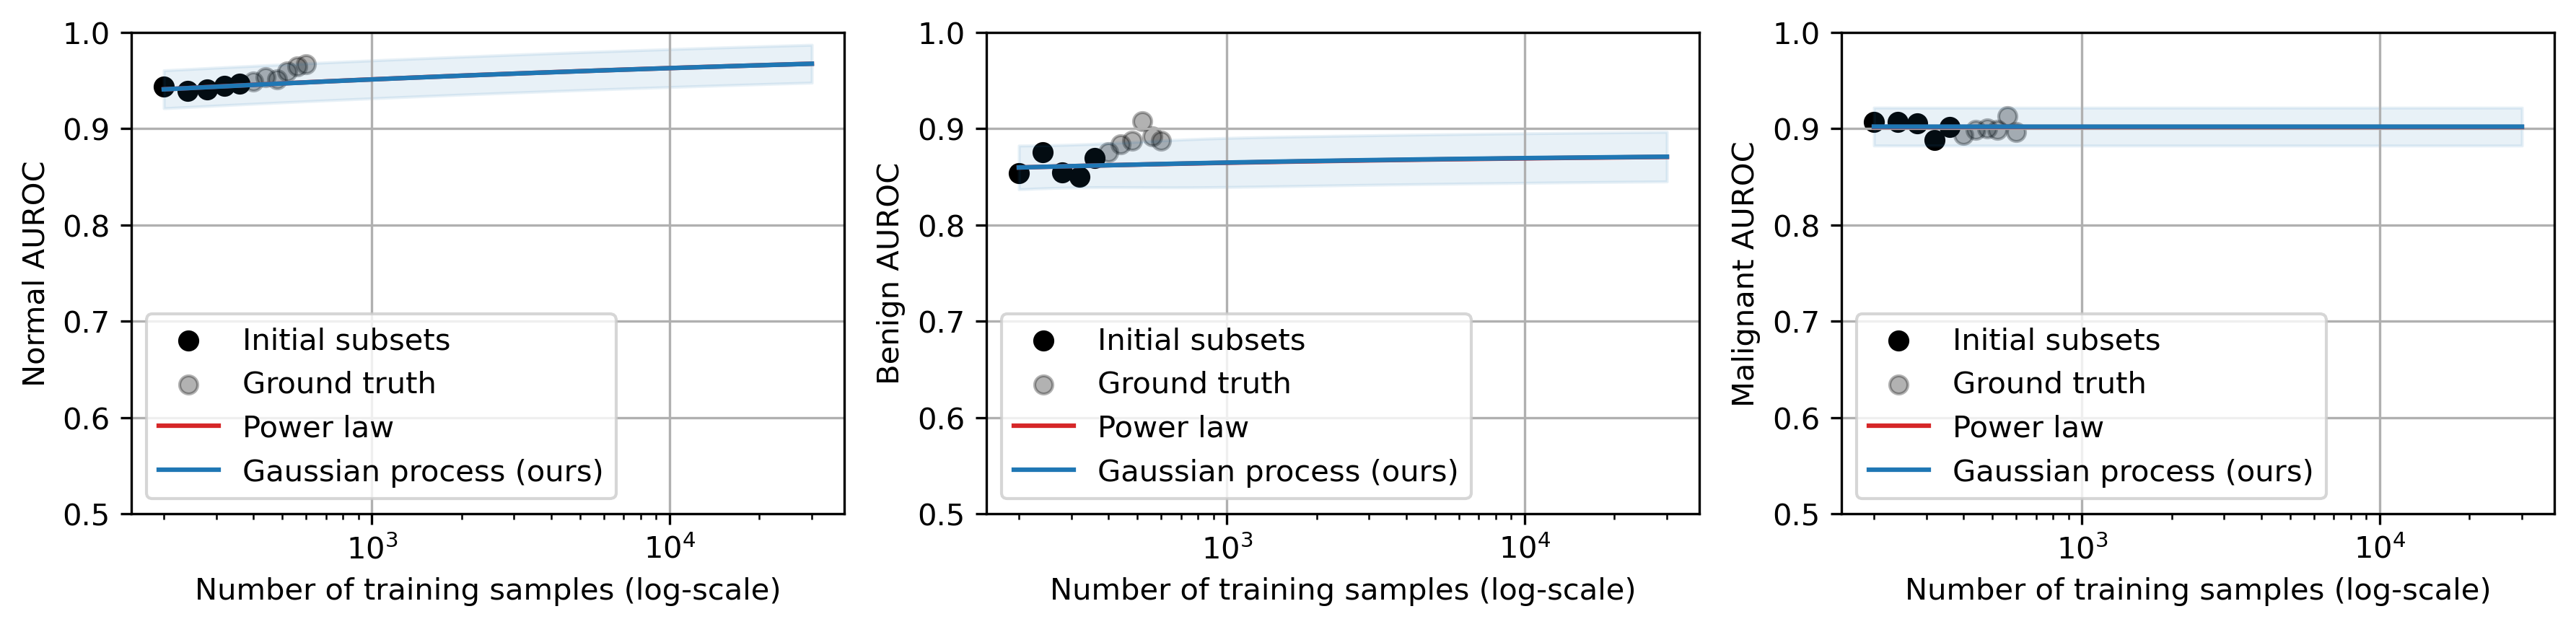

In [4]:
# BUSI (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/BUSI_short_range.csv')
plot_experiment(df, ['Normal', 'Benign', 'Malignant'])

In [ ]:
# OASIS-3 (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_short_range.csv')
plot_experiment(df, ['Alzheimer’s'])

In [ ]:
import seaborn as sns
palette = sns.color_palette().as_hex()
fourth_color = palette[4]
print(fourth_color)

In [ ]:
short_range_experiments = ['/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_short_range.csv',
                           '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_short_range.csv',
                           '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/BUSI_short_range.csv']
short_range_labels = [['Atelectasis', 'Effusion', 'Infiltration'],
                      ['Bacteria', 'Virus'],
                      ['Normal', 'Benign', 'Malignant']]

In [ ]:
def mean_performance(df):
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    return df

In [ ]:
# Short range
ncols, nrows = 4, 6
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), sharex=True, sharey=True, dpi=300)
for dataset_index, (path, labels) in enumerate(zip(short_range_experiments, short_range_labels)):
    df = load_experiment(path)
    df = mean_performance(df)
    for label_index, _ in enumerate(labels):
        # Plot data
        figure_index = dataset_index*4+label_index
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train Gaussian process
        likelihood, model = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Power law (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # Train Gaussian process
        likelihood, model = train_GPArctan(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#d62728', label='Arctan (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#d62728', alpha=0.1)
        # Formatting
        np.array(axs).flatten()[figure_index]\
        .set_xlim([100, 30000])
        np.array(axs).flatten()[figure_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[figure_index]\
        .set_xscale('log')
        np.array(axs).flatten()[figure_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[figure_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[figure_index]\
        .legend()
        np.array(axs).flatten()[figure_index]\
        .grid()
    for index in range(len(labels),4):
        figure_index = dataset_index*4+index
        np.array(axs).flatten()[figure_index]\
        .imshow([[1]], cmap='gray', vmin=0, vmax=1)
        np.array(axs).flatten()[figure_index]\
        .set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
long_range_experiments = ['/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv',
                          '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_long_range.csv']
long_range_labels = [['Atelectasis', 'Effusion', 'Infiltration'],
                     ['Bacteria', 'Virus']]

In [ ]:
# Long range
ncols, nrows = 4, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
for dataset_index, (path, labels) in enumerate(zip(long_range_experiments, long_range_labels)):
    df = load_experiment(path)
    df = mean_performance(df)
    for label_index, _ in enumerate(labels):
        # Plot data
        figure_index = dataset_index*4+label_index
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train Gaussian process
        likelihood, model = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Power law (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # Train Gaussian process
        likelihood, model = train_GPArctan(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#d62728', label='Arctan (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#d62728', alpha=0.1)
        # Formatting
        np.array(axs).flatten()[figure_index]\
        .set_xlim([100, 30000])
        np.array(axs).flatten()[figure_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[figure_index]\
        .set_xscale('log')
        np.array(axs).flatten()[figure_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[figure_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[figure_index]\
        .legend()
        np.array(axs).flatten()[figure_index]\
        .grid()
        np.array(axs).flatten()[label_index]\
        .legend(loc='lower right')
    for index in range(len(labels),4):
        figure_index = dataset_index*4+index
        np.array(axs).flatten()[figure_index]\
        .imshow([[1]], cmap='gray', vmin=0, vmax=1)
        np.array(axs).flatten()[figure_index]\
        .set_axis_off()
fig.tight_layout()
plt.show()